# Linear Systems

Solving linear systems is arguably one of the most fundamental computation in numerics and statistics. Many problems can be reduced to the solution of one or many (large-scale) linear systems.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [9.5, 6]
plt.rcParams['font.size'] = 18 
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsfonts}']

We begin by creating a random linear system with a symmetric positive definite matrix.

In [2]:
import numpy as np
from scipy.sparse import diags
from probnum.linalg import problinsolve
from probnum.linalg.linear_operators import SymmetricKronecker

# Random linear system
np.random.seed(42)
n = 25
k = int(n / 2)
A = diags(np.concatenate([np.arange(1, k + 1), np.arange(k + 1, 0, step=-1)]), 
                  np.arange(-k, k + 1), shape=(n, n)).toarray()  # row covariance
A += np.random.normal(size=(n, n))
A = 0.5 * (A + A.T) + 10 * np.eye(n) # Symmetrize and make diagonally dominant
b = np.random.normal(size=(n, 1))

print("Matrix condition: {:.2f}".format(np.linalg.cond(A)))

Matrix condition: 32.85


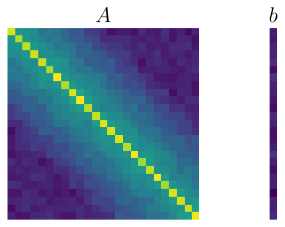

In [3]:
# Plot
matdict = {"$A$": A, "$b$": b}
vmin = np.min([np.min(mat) for mat in list(matdict.values())])
vmax = np.max([np.max(mat) for mat in list(matdict.values())])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3.5))
for i, (title, mat) in enumerate(matdict.items()): 
    axes[i].imshow(mat, vmin=vmin, vmax=vmax)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
fig.tight_layout()

## Prior Information

Prior information is encoded in a random variable. If the prior distribution has a certain covariance structure, this is exploited by the solver by using the matrix-vector product defined by the ``LinearOperator``.

In [4]:
from probnum.probability import RandomVariable, Normal

# Prior distribution on A
covA = SymmetricKronecker(np.eye(n), np.eye(n))
Ainv0 = RandomVariable(shape=A.shape, 
                       dtype=A.dtype, 
                       distribution=Normal(mean=1/np.trace(A) * np.eye(n), cov=covA))

## Probabilistic Linear Solvers

In [5]:
# Probabilistic linear solver
x, Ahat, Ainv, info = problinsolve(A=A, b=b, Ainv0=Ainv0)
print(info)

{'iter': 16, 'maxiter': 250, 'resid_l2norm': 1.1456836044556666e-06, 'conv_crit': 'resid_rtol', 'matrix_cond': None}


 /home/j/.virtualenvs/probnum/lib/python3.6/site-packages/probnum/linalg/linear_solvers.py:372: UserWarning:Prior specified only for Ainv. Inverting prior mean naively. This operation is computationally costly! Specify an inverse prior (mean) instead.


We plot means and a few samples from the resulting distributions on $A$ and $H=A^{-1}$.

In [6]:
# Draw samples
np.random.seed(42)
Ahat_samples = Ahat.sample(3)
Ainv_samples = Ainv.sample(3)


# Plot
rvdict = {"$\mathbb{E}(A^{-1})" : Ainv.mean().todense(), 
          "$A^{-1}_1" : Ainv_samples[0], "$A^{-1}_2" : Ainv_samples[1], 
          "$A^{-1}_3" : Ainv_samples[2]}
vmin = np.min([np.min(mat) for mat in list(rvdict.values())])
vmax = np.max([np.max(mat) for mat in list(rvdict.values())])

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[0, i].imshow(rv, vmin=vmin, vmax=vmax)
    axes[0, i].set_axis_off()
    axes[0, i].title.set_text(title + "$")
    
    axes[1, i].imshow(rv @ A, vmin=vmin, vmax=vmax)
    axes[1, i].set_axis_off()
    axes[1, i].title.set_text(title + "A$")    
plt.tight_layout()

LinAlgError: 10-th leading minor of the array is not positive definite

In [ ]:
# Plot
rvdict = {"$A$" : A, "$\mathbb{E}(\hat{A})$" : Ahat.mean().todense(),
          "$\hat{A}_1$" : Ahat_samples[0], "$\hat{A}_2$" : Ahat_samples[1], "$\hat{A}_3$" : Ahat_samples[2],}
vmin = np.min([np.min(mat) for mat in list(rvdict.values())])
vmax = np.max([np.max(mat) for mat in list(rvdict.values())])

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()